In [2]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
from Cores import Cores
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

from MEM_class import MEM


In [3]:
coreNames = ['B16', 'B17','B18','B19','B20','B21','B22','B23','B26','B27','B28','B29','B30']

DEPy = [False,False,True,True,True,False,True,True,False,False,False,False,False]
ECMy = [True,False,True,False,False,True,False,False,False,False,False,False,False]
DEP_Names = ['B18','B19','B20','B22','B23']
ECM_Names = ['B16','B18','B21']
ECM_DEPCores = []


In [4]:
idx_chosen = [3,6,7]
dfs_LT = []

j = 0
for i in idx_chosen:
    core = coreNames[i]
    dens = pd.read_excel('DepthDensity_Bcores_lowRes.xlsx', sheet_name=core, index=False)
    d18O = pd.read_excel('Depth_d18O__Bcores.xlsx', sheet_name=core, index=False)
    
    if DEPy[i]:
        DEP = pd.read_excel('DepthDEP__BcoresClean.xlsx', sheet_name=core, index=False)
    else:
        DEP = []
    
    if ECMy[i]:
        ECM = pd.read_excel('DepthECM__B16_B18_B21.xlsx', sheet_name=core, index=False)
    else:
        ECM = []
    
    volcWE = np.asarray(pd.read_excel('VolcanicEruptions__WE_Depth.xlsx', 'Sheet1', usecols=[core]))
    ECM_DEPCores.append(Cores(name=core, df_dens=dens, df_d18O = d18O, df_ECM = ECM, df_DEP = DEP, volcWE = volcWE))

    dfs_LT.append(ECM_DEPCores[j].getData_LakiToTambora(plotFig = False))
    j += 1


114

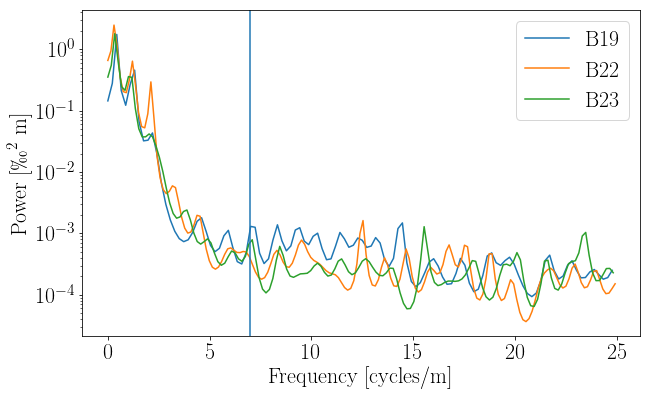

In [158]:
MEM_power = []

figPSD, axPSD = plt.subplots(figsize = (10,6))
axPSD.set(xlabel = 'Frequency [cycles/m]', ylabel = r'Power [$\permil ^2$ m]')
for i in range(len(dfs_LT)):
    d18O_data = np.array(dfs_LT[i][0]['d18O'])
    depth_data = np.array(dfs_LT[i][0]['depth'])


    B_MEM = MEM(t_data = depth_data, y_data = d18O_data,  M = 50)
    MEM_power.append(B_MEM(t_data = depth_data, y_data = d18O_data, M = 50, N = np.size(d18O_data), view = False))
    
    axPSD.semilogy(MEM_power[i][0], MEM_power[i][1], label = coreNames[idx_chosen[i]])
axPSD.axvline(x=7)
axPSD.legend()
len(MEM_power[0][0])

In [183]:
dfs_LT[0][0]

,depth,d18O
1021,32.58,-36.3418
1022,32.60,-36.5735
1023,32.62,-36.9274
1024,32.64,-37.0577
1025,32.66,-37.5405
...,...,...
1244,37.04,-36.5838
1245,37.06,-36.7828
1246,37.08,-36.6757
1247,37.10,-36.7628


In [197]:
def func_PSDm(w, P0, s_tot2, a1, s_eta2):
    dz = 0.02
    k = 2 * np.pi * w
    compArr = -k*dz*1j
    return P0 * np.exp(-k**2 * s_tot2) + (s_eta2 * dz)/(abs(1 + a1 * np.exp(compArr))**2)



def func_Noise(w, s_eta2, a1):
    dz = 0.02
    return (s_eta2 * dz) / (abs(1 + a1 * np.exp(- 2 * np.pi * 1j * w * dz))**2)



def func_Signal(w, p0, s_tot2):
    return p0 * np.exp(- (2 * np.pi * w)**2 * s_tot2)


idx = 1
d18O_data_2 = dfs_LT[idx][0]['d18O']
depth_data_2 = dfs_LT[idx][0]['depth']
x_all = MEM_power[idx][0]
y_all = MEM_power[idx][1]

x = MEM_power[idx][0][MEM_power[idx][0] < 5]
y = MEM_power[idx][1][MEM_power[idx][0] < 5]

x_noise = MEM_power[idx][0][MEM_power[idx][0] >= 5]
y_noise = MEM_power[idx][1][MEM_power[idx][0] >= 5]

In [198]:
from scipy.optimize import curve_fit

popt_Signal, pcov_Signal = curve_fit(func_Signal, x, y)
popt_Noise, pcov_Noise = curve_fit(func_Noise, x_noise, y_noise, bounds=([-100,-100],[100,100]))

/home/thea/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [199]:
s_eta2_est = popt_Noise[0]
a1_est = popt_Noise[1]
p0_est = popt_Signal[0]
s_tot2_est = popt_Signal[1]
s_tot2_est

0.03310362467158383

In [200]:
y_test = func_Signal(x, p0_est, s_tot2_est)
y_testAll = func_Signal(x_all, p0_est, s_tot2_est)

y_noiseTest = func_Noise(x_all, s_eta2_est, a1_est)


y_ALL = y_testAll + y_noiseTest

[(3.1622776601683795e-05, 3.1622776601683795)]

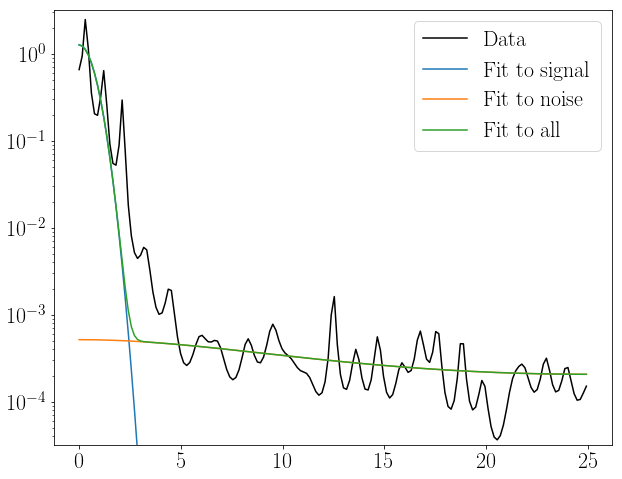

In [201]:
figTest, axTest = plt.subplots(figsize=(10,8))


axTest.semilogy(x_all, y_all, color='k', label='Data')
axTest.semilogy(x, y_test, label='Fit to signal')
axTest.semilogy(x_all, y_noiseTest, label='Fit to noise')

axTest.semilogy(x_all, y_ALL, label='Fit to all')
axTest.legend()
axTest.set(ylim = (10**-4.5,10**0.5) )

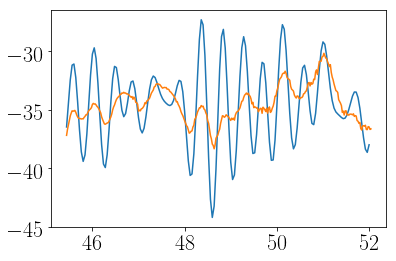

In [205]:
filt = y_testAll/y_ALL
trans = np.exp(- ((2 * np.pi * x_all)**2 * s_tot2_est) / 2)
transInv = 1/trans

d18O_mean = np.mean(np.array(d18O_data_2))
F = np.fft.fft(d18O_data_2[1:-1:2]) * filt[:-1] * transInv[:-1]
f = np.fft.ifft(F)
plt.plot(depth_data_2[0:-1:2], f)
plt.plot(depth_data_2,np.array(d18O_data_2))